In [1]:
# make sure your graphviz installation is in path
%env PATH

'/home/nlplab/joaw/miniconda3/envs/nlp/bin:/home/nlplab/joaw/bin:/home/nlplab/joaw/miniconda3/bin:/home/nlplab/joaw/miniconda3/condabin:/home/nlplab/joaw/.zinit/polaris/bin:/usr/local/bin:/usr/local/sbin:/home/nlplab/joaw/.cargo/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin'

In [2]:
import os
with open(os.path.join('data', 'ALG_abstract.txt'), 'r') as f:
    data = f.read()

In [3]:
data[:100]

'Many natural language questions (e.g., “What is a hard disk?”) are submitted to search engines on th'

In [4]:
with open(os.path.join('data', 'stopwords.txt'), 'r') as f:
    STOPWORD = f.read().split()

In [5]:
print(STOPWORD)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

## Graph representation

ref: https://towardsdatascience.com/structuring-text-with-graph-representations-41dd4f2a3ab3

Transform free text into the graph representation.  
Preprocess:
 1. remove all punctuations
 2. stop words are removed

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

from spacy import load
from itertools import chain
from collections import Counter

In [7]:
PUNC = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”'
model = load('en_core_web_sm')

In [8]:
def build_graph(doc, directed = False, weighted = False):
    pdoc = preprocess_document(doc)
    
    nodes = get_entities(pdoc)
    edges = get_relations(pdoc, weighted)
    
    # create graph structure with NetworkX
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(nodes)
    if weighted:
        G.add_weighted_edges_from(edges)
    else:
        G.add_edges_from(edges)
    
    return G

In [9]:
def preprocess_document(document, stopwords=STOPWORD, punc=PUNC):
    """
    1. tokenized with spacy model
    2. punctuations are removed if punc is specified
    3. stopwords are removed if stopwords is specified
    """
    def useful(word): return word.strip() and word not in stopwords and word not in punc
    
    doc = model(document)
    doc = [[token.text.lower() for token in sent] 
                               for sent in doc.sents]
    doc = [list(filter(useful, sent)) for sent in doc]
    return doc

In [10]:
def get_entities(document):
    """ Generate nodes on the graph, which should be all unique words """
    unique_words = list(set(chain(*document)))
    return unique_words

In [11]:
def ngram(tokens, n=2):
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [12]:
def get_relations(document, weighted=False):
    """ Generate edges on the graph, which should be all bigram connections """
    bigrams = [ngram(sent, 2) for sent in document]
    bigrams = Counter(chain(*bigrams))
    if not weighted:
        return [ gram.split(' ') for gram in bigrams ]
    return [ [*gram.split(' '), count] for gram, count in bigrams.items() ]

In [13]:
def plot_graph(G, title=None, highlight=None):
    """ 
    Display graph on the notebook. 
    Some errors may come up in `nx.draw_networkx_edge_labels`;
      you need to install graphviz first and then pygraphviz, 
      and make sure your graphviz installation is in your system path. (See the first cell)
    """
    
    # set figure size
    plt.figure(figsize=(12,12))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True, node_size=200, node_color='#6495ed')
    
    # draw highlighted nodes
    if highlight:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=highlight, node_size=250, node_color='#90ee90')
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return

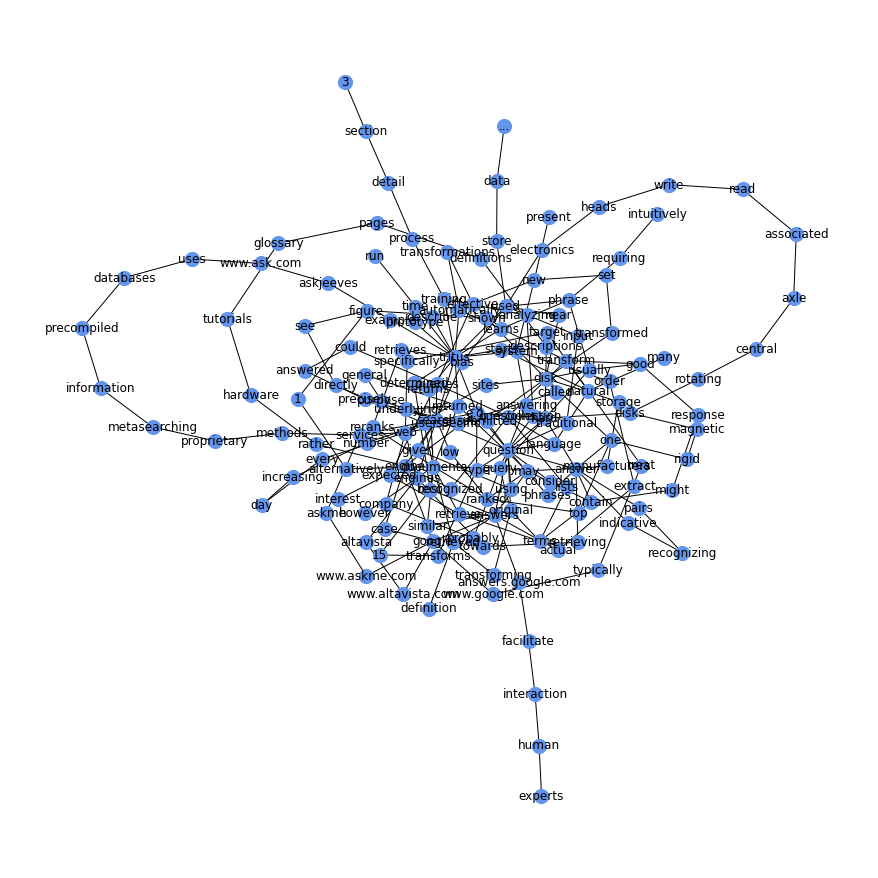

In [14]:
G_undirected = build_graph(data)
plot_graph(G_undirected)

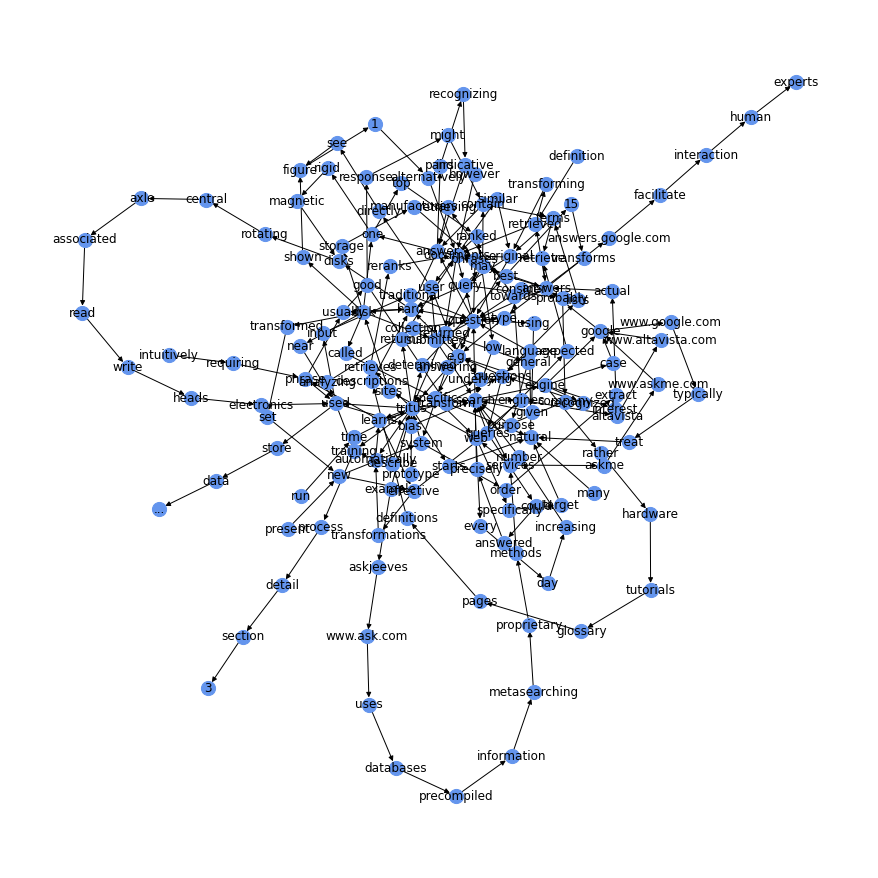

In [15]:
G_directed = build_graph(data, directed=True)
plot_graph(G_directed)

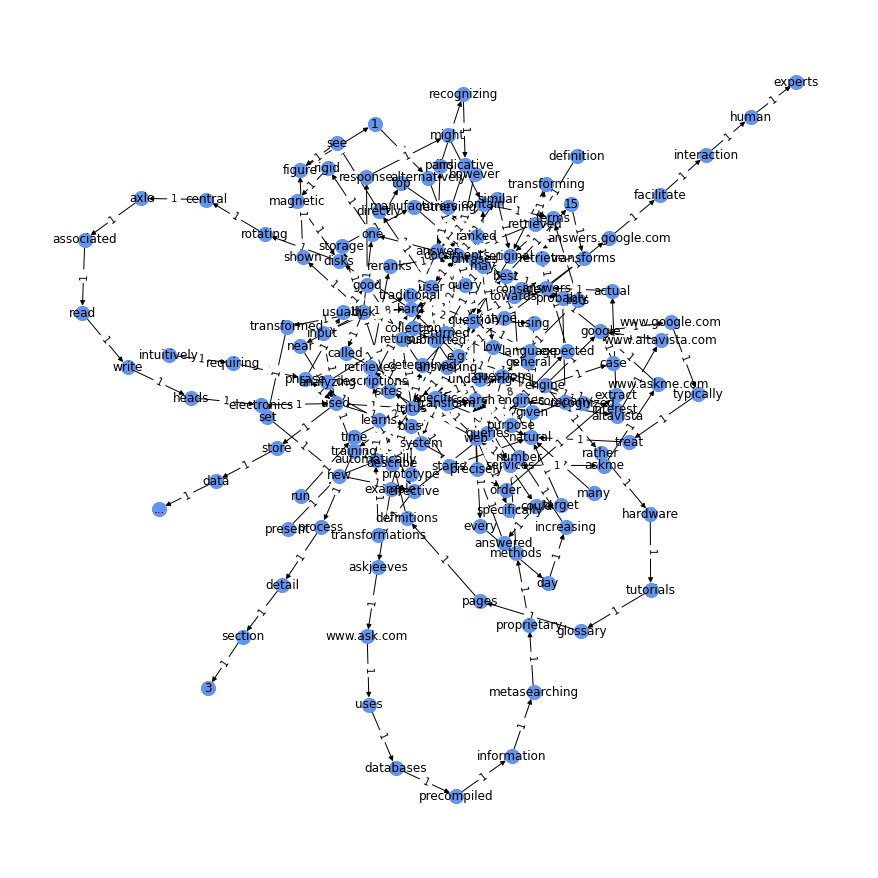

In [16]:
G_weighted = build_graph(data, directed=True, weighted=True)
plot_graph(G_weighted)

## Sample usage

ref: https://towardsdatascience.com/keyphrase-extraction-with-graph-centrality-989e142ce427

Use centrality algorithms provided in NetworkX to get potential important nodes.  

 + Available algorithm list: https://networkx.org/documentation/stable/reference/algorithms/centrality.html
 + Wikipedia: https://en.wikipedia.org/wiki/Centrality

In [17]:
def print_highest(scores: dict, n=10):
    sorted_scores = sorted(scores.items(), key=lambda item: -item[1])
    print(f' word           score')
    print(f'---------------------')
    for idx, (token, score) in enumerate(sorted_scores):
        if idx > n: break
            
        print(f'{token:15} {score:.2f}')

In [18]:
node_scores = nx.betweenness_centrality(G_directed)
print_highest(node_scores, 20)

 word           score
---------------------
search          0.32
question        0.30
tritus          0.21
hard            0.17
disk            0.15
e.g.            0.14
engine          0.13
documents       0.11
web             0.10
used            0.10
answers         0.10
answer          0.07
submitted       0.07
returned        0.07
services        0.07
google          0.07
query           0.06
may             0.05
disks           0.05
rotating        0.05
central         0.05


In [19]:
def get_keywords(scores:dict, n:int = None):
    sorted_scores = sorted(scores.items(), key=lambda item: -item[1])
    if not n:
        n = int(len(node_scores) / 3)
    return [token for token, _ in sorted_scores[:n]]

In [22]:
keywords = get_keywords(node_scores, int(len(node_scores)/3))
keywords[:10]

['search',
 'question',
 'tritus',
 'hard',
 'disk',
 'e.g.',
 'engine',
 'documents',
 'web',
 'used']

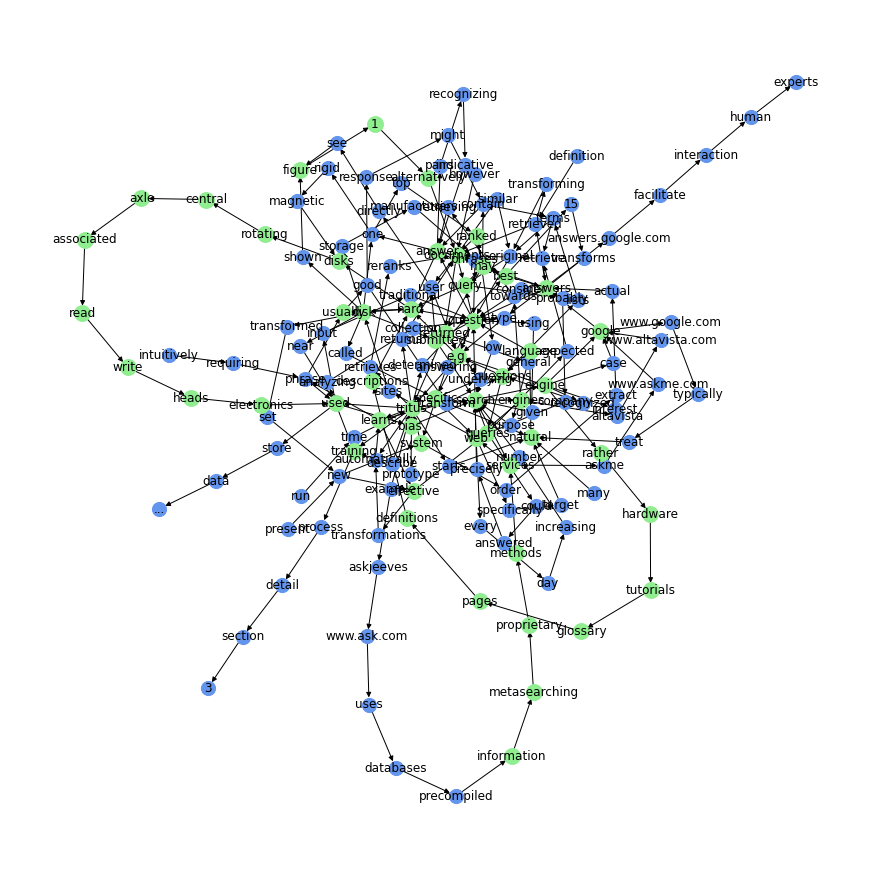

In [23]:
G_directed = build_graph(data, directed=True)
plot_graph(G_directed, highlight=keywords)